In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import math
import seaborn as sns
from cvx.covariance.combination import from_ewmas
from arch import arch_model
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from scipy.optimize import minimize
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [ ]:
#Ensemble des librairies utilisées
from xbbg import blp
import datetime
import numpy as np
import pandas as pd
import time
import os
import tensorflow as tf
from datetime import datetime
from dateutil.relativedelta import relativedelta
from scipy import stats


from pylatex import Document, Section, Subsection, Math, Table, Tabular, Figure, Command, MiniPage
from pylatex.utils import NoEscape
import subprocess
from pylatex.utils import bold
from pylatex.package import Package
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from plotly.subplots import make_subplots
from tensorflow.keras.initializers import GlorotUniform
from keras.layers import Dropout
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [2]:
df=pd.read_csv(r'C:\Users\33640\OneDrive\Documents\GitHub\Covariance-Correlation-Volatility-Forecasting\SP500_daily_returns.csv')
nan_counts=df.isna().sum()
columns_to_keep = nan_counts[nan_counts <= 3].index
returns = df[columns_to_keep]
returns=returns.dropna()
returns.shape
dates=returns['Date'] 
returns=returns.drop('Date', axis=1)

4966->fin: période de back-test

In [8]:
def histo_cov(df, date, window):
    cov=np.zeros((len(df.columns),len(df.columns)))
    for i in range(date-window+1, date+1):
        cov+=np.outer(np.array(df.iloc[i,:]),np.array(df.iloc[i,:]))/(window)
    covs=pd.DataFrame(cov*250, columns=df.columns, index=df.columns)
    return(covs)

In [9]:
def ewma_cov(df, date, window, beta):
    cov=np.zeros((len(df.columns),len(df.columns)))
    for i in range(date-window+1, date+1):
        cov=(beta)*cov+(1-beta)*np.outer(np.array(df.iloc[i,:]),np.array(df.iloc[i,:]))
    covs=pd.DataFrame(cov*250, columns=df.columns, index=df.columns)
    return(covs)

In [58]:
halflife_pairs=[(10, 21), (21, 63), (63, 125)]
def ewma_cov(df, date, halflife_pairs, window):    
    combinator = from_ewmas(df.iloc[max(0,date-1000):date,:],
                                halflife_pairs,
                                min_periods_vola=window,  # min periods for volatility estimation
                                min_periods_cov=window)  # min periods for correlation estimation

    # Solve combination problem and loop through combination results to get predictors
    covariance_predictors = {}
    for predictor in combinator.solve(window=10):  # lookback window for optimization
        # From predictor we can access predictor.time, predictor.mean (=0 here),
        # predictor.covariance, and predictor.weights
        covariance_predictors[predictor.time] = predictor.covariance
    return(covariance_predictors[date]*250)
    

In [77]:
def forecast_volatility_garch(returns, date, horizon=1):
    n_assets = returns.shape[1]
    
    # Initialiser les matrices pour stocker les volatilités prévues
    forecast_volatilities = np.zeros((n_assets,))
    
    for i in range(n_assets):
        # Ajuster le modèle GARCH(1,1) pour chaque actif
        asset_returns = returns.iloc[:date, i] *100
        model = arch_model(asset_returns, vol='Garch', p=1, q=1)
        garch_fit = model.fit(disp="off")
        
        # Prédire les volatilités à horizon k
        forecasts = garch_fit.forecast(horizon=horizon)
        forecast_vol = np.sqrt(forecasts.variance.iloc[-1]*250)/100
        forecast_volatilities[i] = forecast_vol.values[-1]
    
    # Retourner un DataFrame avec les volatilités prédites
    return np.array(forecast_volatilities)

In [78]:
forecast_volatility_garch(returns, 1000, horizon=1)

array([0.29921204, 0.39910446, 0.19859399, 0.22945401, 0.46582778,
       0.3671927 , 0.20410848, 0.24199301, 0.37360032, 0.11442435])

In [67]:
# Step 1: Fit GARCH(1,1) to each asset's returns
def fit_garch(returns):
    # Rescaler les rendements
    returns_rescaled = returns * 100
    
    model = arch_model(returns_rescaled, vol='Garch', p=1, q=1)
    garch_fit = model.fit(disp="off")
    
    # Revenir à l'échelle d'origine pour les résidus
    residuals = garch_fit.resid / 100
    volatilities = garch_fit.conditional_volatility / 100
    return volatilities, residuals
# Step 2: DCC-GARCH log-likelihood function
def dcc_garch_log_likelihood(params, residuals):
    """
    Calcule la log-vraisemblance du modèle DCC-GARCH.
    
    Paramètres:
    params (tuple): Paramètres alpha_2 et beta_2.
    residuals (np.array): Matrice des résidus standardisés (T x N).
    
    Retourne:
    float: La valeur de la log-vraisemblance négative.
    """
    alpha_2, beta_2 = params
    n_assets = residuals.shape[1]
    
    # Initialisation de Q_bar et Q_t
    T = residuals.shape[0]
    Q_bar = np.cov(residuals.T)  # Matrice de corrélation inconditionnelle
    Q_t = Q_bar.copy()
    
    log_likelihood = 0
    epsilon = 1e-5  # Petit terme de régularisation pour éviter les matrices singulières
    
    for t in range(T):
        # Mise à jour de Q_t selon la formule DCC
        Q_t = (1 - alpha_2 - beta_2) * Q_bar + alpha_2 * np.outer(residuals[t], residuals[t]) + beta_2 * Q_t
        
        # Régularisation de la diagonale de Q_t pour éviter les valeurs négatives
        diag_Q_t = np.diag(Q_t)
        diag_Q_t = np.clip(diag_Q_t, epsilon, None)  # Clip des valeurs négatives ou proches de zéro
        Q_t = np.diag(diag_Q_t) + (Q_t - np.diag(np.diag(Q_t)))  # Remplacer la diagonale
        
        # Ajouter un petit terme de régularisation à Q_t
        Q_t += epsilon * np.eye(n_assets)
        
        # Normaliser Q_t pour obtenir R_t (matrice de corrélation dynamique)
        D_t = np.diag(1 / np.sqrt(np.diag(Q_t)))
        R_t = D_t @ Q_t @ D_t
        
        # Vérifier les valeurs propres de R_t et corriger si nécessaire
        eigenvalues = np.linalg.eigvals(R_t)
        if np.any(eigenvalues <= 0):
            R_t += epsilon * np.eye(n_assets)
        
        # Calcul de la log-vraisemblance pour chaque étape t
        try:
            term1 = np.log(np.linalg.det(R_t))  # Log du déterminant de R_t
        except np.linalg.LinAlgError:
            # En cas de matrice singulière
            return np.inf  # Retourner une grande valeur pour pénaliser l'optimisation
        
        term2 = residuals[t].T @ np.linalg.pinv(R_t) @ residuals[t]  # epsilon_t' R_t^{-1} epsilon_t
        term3 = residuals[t].T @ residuals[t]  # epsilon_t' epsilon_t
        log_likelihood += term1 + term2 + term3  # Ajouter les trois termes pour chaque t
    
    # Retourner la log-vraisemblance négative
    return 0.5 * log_likelihood

# Step 6: Optimization of alpha_2 and beta_2
def optimize_dcc_garch(returns):
    """
    Optimise les paramètres alpha_2 et beta_2 du modèle DCC-GARCH en utilisant une fenêtre de données.
    
    Paramètres:
    returns (pd.DataFrame): DataFrame des rendements journaliers des actifs (chaque colonne représente un actif).
    window (str): Fenêtre temporelle pour la sélection des données ('6M' pour 6 mois, '1Y' pour 1 an, etc.).
    
    Retourne:
    tuple: Paramètres optimisés alpha_2 et beta_2.
    """
    n_assets = returns.shape[1]
    
    # Ajuster GARCH(1,1) sur chaque actif et standardiser les résidus
    volatilities = np.zeros_like(returns)
    residuals = np.zeros_like(returns)
    
    for i in range(n_assets):
        volatilities[:, i], residuals[:, i] = fit_garch(returns.iloc[:, i])
    
    standardized_residuals = residuals / volatilities
    
    # Valeurs initiales pour alpha_2 et beta_2
    initial_params = np.array([0.05, 0.9])
    
    # Contraintes sur les paramètres
    bounds = [(0, 1), (0, 0.95)]  # Limiter beta_2 à 0.95 pour éviter une convergence lente
    
    # Minimiser la log-vraisemblance négative
    result = minimize(dcc_garch_log_likelihood, initial_params, args=(standardized_residuals), bounds=bounds, method='SLSQP', options={'disp': True})
    
    if result.success:
        optimized_params = result.x
        return optimized_params
    else:
        raise ValueError("Optimization failed")

def predict_covariance_dcc_garch(df, date, window, horizon=1):
    """
    Calcule la matrice de covariance prédite par le modèle DCC-GARCH à un horizon donné.
    
    Paramètres:
    returns (pd.DataFrame): DataFrame des rendements journaliers des actifs (chaque colonne représente un actif).
    window (str): Fenêtre temporelle pour la sélection des données ('6M' pour 6 mois, '1Y' pour 1 an, etc.).
    horizon (int): Nombre de jours dans le futur pour lesquels la covariance doit être prédite.
    
    Retourne:
    pd.DataFrame: Matrice de covariance prédite à l'horizon spécifié.
    """
    returns=df.iloc[date-window:date,:]
    n_assets = returns.shape[1]
    
    # Ajuster GARCH(1,1) sur chaque actif et standardiser les résidus
    volatilities = np.zeros_like(returns)
    residuals = np.zeros_like(returns)
    
    for i in range(n_assets):
        volatilities[:, i], residuals[:, i] = fit_garch(returns.iloc[:, i])
    
    standardized_residuals = residuals / volatilities
    
    # Initialiser les paramètres DCC-GARCH avec les valeurs optimisées
    optimized_alpha2, optimized_beta2 = optimize_dcc_garch(returns)
    
    # Initialisation de Q_bar et Q_t
    Q_bar = np.cov(standardized_residuals.T)
    Q_t = Q_bar.copy()
    T = standardized_residuals.shape[0]
    
    # Utiliser les paramètres optimisés pour prédire la covariance
    for t in range(T):
        Q_t = (1 - optimized_alpha2 - optimized_beta2) * Q_bar + optimized_alpha2 * np.outer(standardized_residuals[t], standardized_residuals[t]) + optimized_beta2 * Q_t
    
    # Normaliser Q_t pour obtenir la matrice de corrélation dynamique R_t à la dernière date
    D_t = np.diag(1 / np.sqrt(np.diag(Q_t)))
    R_t = D_t @ Q_t @ D_t
    
    # Prédire la matrice de covariance à horizon k jours
    last_volatilities = volatilities[-1, :]
    D_last = np.diag(last_volatilities)
    predicted_covariance = D_last @ R_t @ D_last
    
    # Boucle pour étendre la prédiction à horizon k jours
    for _ in range(horizon):
        # Mettre à jour Q_t pour chaque jour à venir
        Q_t = (1 - optimized_alpha2 - optimized_beta2) * Q_bar + optimized_beta2 * Q_t
        
        # Normaliser Q_t pour obtenir R_t (corrélation dynamique après k jours)
        D_t = np.diag(1 / np.sqrt(np.diag(Q_t)))
        R_t = D_t @ Q_t @ D_t
        
        # Mise à jour des volatilités pour chaque jour
        predicted_covariance = D_last @ R_t @ D_last
    
    # Retourner la matrice de covariance sous forme de DataFrame avec les colonnes et index des actifs
    return pd.DataFrame(predicted_covariance*250, index=returns.columns, columns=returns.columns)

In [231]:
def reg_RW_vols(df, date, windows):
    Har_vols = []
    for actif in df.columns:
        vols=[[] for i in range(len(windows))]
        vol_realized = []
        M=max(windows)
        for t in range(date-250, date ):
            for i, window in enumerate(windows):
                if window>1:
                    vols[i].append(df.loc[t - window+1:t, actif].std() * np.sqrt(250))
                else:
                    vols[i].append(np.sqrt(df.loc[t , actif]**2 * 250))
            vol_realized.append(np.sqrt(df.loc[t+1 , actif]**2 * 250))
        vol_data = pd.DataFrame({f'vol_{i+1}': vols[i] for i in range(len(windows))})
        vol_data['vol_realized'] = vol_realized
        vol_data = vol_data.dropna()
        
        X = vol_data[[f'vol_{i+1}' for i in range(len(windows))]]
        X = add_constant(X)
        y = vol_data['vol_realized']
        model = OLS(y, X).fit()
        latest_vols={}
        latest_vols['intercept'] = [1]
        for i, window in enumerate(windows):
            if window>1:
                latest_vols[f'vol_{i+1}']=[df.loc[date - window+1:date, actif].std() * np.sqrt(250)] 
            else:
                latest_vols[f'vol_{i+1}']=[np.sqrt(df.loc[date, actif]**2 * np.sqrt(250))] 
        
        latest_data = pd.DataFrame(latest_vols)
        vol_forecast = model.predict(latest_data)
        Har_vols.append(vol_forecast.iloc[0])
    
    return (np.array(Har_vols))

In [304]:
def winsorize_series(series, lower_quantile=0.02, upper_quantile=0.98):
    """
    Remplace les valeurs extrêmes par les quantiles 5% et 95%.
    """
    lower_bound = series.quantile(lower_quantile)
    upper_bound = series.quantile(upper_quantile)
    series_winsorized = series.clip(lower=lower_bound, upper=upper_bound)
    return series_winsorized

def winsorize_dataframe(df, lower_quantile=0.02, upper_quantile=0.98):
    """
    Applique la winsorisation sur chaque colonne d'un DataFrame.
    """
    return df.apply(lambda col: winsorize_series(col, lower_quantile, upper_quantile))

def reg_model_vols(df, date, windows):
    def ewma_vol(df, date, actif, beta):
        vol = 0
        for t in range(date - 100 + 1, date + 1):
            vol = beta * vol + (1 - beta) * df.loc[t, actif]**2
        return np.sqrt(vol * 250)

    def ewma_ret(df, date, actif, beta):
        ret = 0
        for t in range(date - 50 + 1, date + 1):
            ret = beta * ret + (1 - beta) * df.loc[t, actif]
        return ret * 250

    Har_vols = []
    for actif in df.columns:
        vols = [[] for _ in range(len(windows))]
        vol_realized = []
        ewma_vols = []
        ewma_returns = []
        neg_vols = []
        avg_vols = []
        M = max(windows)

        # Boucle sur la période pour construire les variables
        for t in range(date - 500, date ):
            for i, window in enumerate(windows):
                if window > 1:
                    vols[i].append(df.loc[t - window + 1:t, actif].std() * np.sqrt(250))
                else:
                    vols[i].append(np.sqrt(df.loc[t, actif]**2 * 250))
            vol_realized.append(np.sqrt(df.loc[t + 1, actif]**2 * 250))

            ewma_vols.append(ewma_vol(df, t, actif, 0.94))
            ewma_returns.append(ewma_ret(df, t, actif, 0.94))

            # Calcul de la volatilité des rendements négatifs sur 5 jours
            neg_returns = df.loc[t - 4:t, actif][df.loc[t - 4:t, actif] < 0]
            if len(neg_returns) == 0:
                neg_vols.append(0)
            elif len(neg_returns) == 1:
                neg_vols.append(np.sqrt(neg_returns.iloc[0] ** 2 * 250))
            else:
                neg_vols.append(neg_returns.std() * np.sqrt(250))

            # Calcul de la volatilité moyenne sur 5 jours pour tous les actifs
            avg_vols.append(df.loc[t - 4:t].std(axis=1).mean() * np.sqrt(250))

        # Mettre les données en DataFrame
        vol_data = pd.DataFrame({f'vol_{i+1}': vols[i] for i in range(len(windows))})
        vol_data['vol_realized'] = vol_realized
        vol_data['ewma_vol'] = ewma_vols
        vol_data['ewma_return'] = ewma_returns
        vol_data['neg_vol'] = neg_vols
        vol_data['avg_vol'] = avg_vols
        vol_data = vol_data.dropna()

        # Appliquer la winsorisation
        vol_data = winsorize_dataframe(vol_data)

        # Sélectionner les variables explicatives et la variable cible
        X = vol_data[[f'vol_{i+1}' for i in range(len(windows))] + ['ewma_vol', 'ewma_return', 'neg_vol', 'avg_vol']]
        y = vol_data['vol_realized']

        # Normaliser les données (centrage autour de 0 et écart-type 1)
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Appliquer la régression Ridge (ou Lasso)
        model = Lasso(alpha=0.01)  # Remplacer par Lasso(alpha=0.1) pour L1 régularisation
        model.fit(X_scaled, y)

        # Prédiction des volatilités futures
        latest_vols = {}
        for i, window in enumerate(windows):
            if window > 1:
                latest_vols[f'vol_{i+1}'] = [df.loc[date - window + 1:date, actif].std() * np.sqrt(250)]
            else:
                latest_vols[f'vol_{i+1}'] = [np.sqrt(df.loc[date, actif] ** 2 * 250)]

        latest_vols['ewma_vol'] = [ewma_vol(df, date, actif, 0.94)]
        latest_vols['ewma_return'] = [ewma_ret(df, date, actif, 0.94)]

        neg_returns = df.loc[date - 4:date, actif][df.loc[date - 4:date, actif] < 0]
        if len(neg_returns) == 0:
            latest_vols['neg_vol'] = [0]
        elif len(neg_returns) == 1:
            latest_vols['neg_vol'] = [np.sqrt(neg_returns.iloc[0] ** 2) * 250]
        else:
            latest_vols['neg_vol'] = [neg_returns.std() * np.sqrt(250)]

        latest_vols['avg_vol'] = [df.loc[date - 4:date].std(axis=1).mean() * np.sqrt(250)]

        latest_data = pd.DataFrame(latest_vols)

        # Normaliser les nouvelles données pour la prédiction
        latest_vols_scaled = scaler.transform(latest_data)
        vol_forecast = model.predict(latest_vols_scaled)
        vol_forecast = np.clip(vol_forecast[0], 0.02, 0.5)
        if vol_forecast==0.02:
            vol_forecast=ewma_vol(df, date, actif, 0.94)
        Har_vols.append(vol_forecast)
    return np.array(Har_vols)

Backtest

In [344]:
def realized_vols(df,date,horizon):
    if horizon==1:
        return(np.array([np.sqrt(df.loc[date+1,actif]**2*250) for actif in df.columns]))
    if horizon>1:
        return(np.array([df.loc[date+1:date+horizon,actif].std()*np.sqrt(250) for actif in df.columns]))
def histo_vols(df,date,window):
    if window==1:
        return(np.array([np.sqrt(df.loc[date,actif]**2*250) for actif in df.columns]))
    if window>1:
        return(np.array([df.loc[date-window+1:date,actif].std()*np.sqrt(250) for actif in df.columns]))
def ewma_vols(df, date, window, beta):
    vol=np.zeros((len(df.columns)))
    for i in range(date-window, date):
        vol=(beta)*vol+(1-beta)*np.sqrt(np.square(np.array(df.iloc[i,:]))*250)
    return(vol)
const_vol=[[] for i in range(returns.shape[1])]
C=[0 for i in range(returns.shape[1])]
for t in range(4000):
    for i in range(len(returns.columns)):
        C[i]+=np.sqrt(returns.iloc[t,i]**2*250)/4000
Realized_vol=[[] for i in range(returns.shape[1])]
histo_vol1=[[] for i in range(returns.shape[1])]
histo_vol5=[[] for i in range(returns.shape[1])]
ewma_vol94=[[] for i in range(returns.shape[1])]
garch_vol=[[] for i in range(returns.shape[1])]
har_vol=[[] for i in range(returns.shape[1])]
reg_vol=[[] for i in range(returns.shape[1])]
for t in range(4966, returns.shape[0]-1):
    if t%50==0:
        print(t)
    i=0
    realized=realized_vols(returns, t, 1)
    histo1=histo_vols(returns,t,1)
    histo5=histo_vols(returns,t,5)
    ewma94=ewma_vols(returns, t,250, 0.945)
    garch=forecast_volatility_garch(returns, t, horizon=1)
    har=reg_RW_vols(returns, t, [1,5,21])
    reg=reg_model_vols(returns, t, [1,5,21])
    for actif in returns.columns:
        const_vol[i].append(C[i])
        Realized_vol[i].append(realized[i])
        histo_vol1[i].append(histo1[i])
        histo_vol5[i].append(histo5[i])
        ewma_vol94[i].append(ewma94[i])
        garch_vol[i].append(garch[i])
        har_vol[i].append(har[i])
        reg_vol[i].append(reg[i])
        i+=1

5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200


In [372]:
garch_vol[0]=garch_vol[0][:1257]

In [367]:
for i in range(returns.shape[1]):
    print(len(histo_vol5[i]))

1257
1257
1257
1257
1257
1257
1257
1257
1257
1257


In [354]:
ewma_vol94=[[] for i in range(returns.shape[1])]
har_vol=[[] for i in range(returns.shape[1])]
for t in range(4966, returns.shape[0]-1):
    if t%100==0:
        print(t)
    i=0
    ewma94=ewma_vols(returns, t,250, 0.86)
    har=reg_RW_vols(returns, t, [1,4,11])
    for actif in returns.columns:
        ewma_vol94[i].append(ewma94[i])
        har_vol[i].append(har[i])
        i+=1


5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200


In [373]:
models_vol=[histo_vol1,histo_vol5,ewma_vol94,garch_vol,har_vol,reg_vol, const_vol]

In [171]:
def mean_squared_error(realized_vol, model_vol):
    total_error = 0
    total_periods = 0
    for i in range(len(realized_vol)):
        total_error += np.sum((np.array(realized_vol[i]) - np.array(model_vol[i])) ** 2)
        total_periods += len(realized_vol[i])
    mse = total_error / total_periods
    return mse

In [139]:
def r_squared(realized_vol, model_vol):
    r2=[]
    for i in range(len(realized_vol)):
        r2.append(r2_score(realized_vol[i], model_vol[i]))
    return(np.mean(np.array(r2)))

In [374]:
for model_vol in models_vol:
    print(mean_squared_error(Realized_vol, model_vol))

0.07906569618817734
0.05916065463383119
0.04533205724376124
0.05356704472320767
0.046239385754538495
0.04764816064181617
0.05578847799756603


In [241]:
def plot_realized_vs_predicted_per_model(realized_vol, model_vol):
    """
    Trace les volatilités réalisées et prédites pour chaque actif et chaque modèle dans un graphique distinct.
    
    Paramètres:
    - realized_vol (list of lists): Volatilités réalisées (une sous-liste par actif).
    - model_vols (list of lists): Volatilités prédites par les modèles (une sous-liste par actif).
    - model_names (list of str, optional): Noms des modèles pour l'affichage. Doit correspondre au nombre de modèles fournis.
    """
    n_assets = len(realized_vol)

    
    # Boucle sur chaque actif
    for i in range(n_assets):
        plt.figure(figsize=(10, 6))
        
        # Tracer les volatilités réalisées
        plt.plot(realized_vol[i], label='Realized Volatility', color='black', linewidth=2)
        
        # Tracer les volatilités prédites pour le modèle j
        plt.plot(model_vol[i], label=f'Predicted Volatility', linestyle='--')
        
        # Ajouter des titres et légendes
        plt.title(f'Volatility for Asset {i+1}')
        plt.xlabel('Time')
        plt.ylabel('Volatility')
        plt.legend()
        plt.grid(True)
        plt.show()

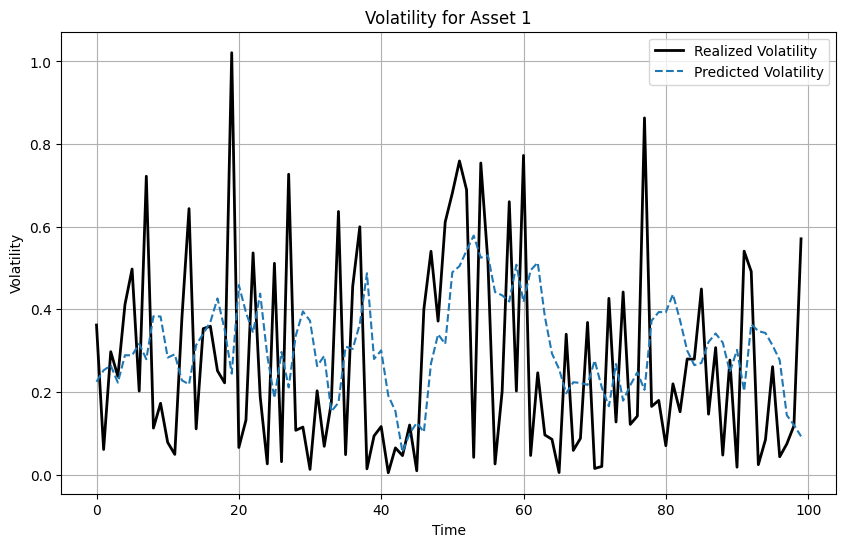

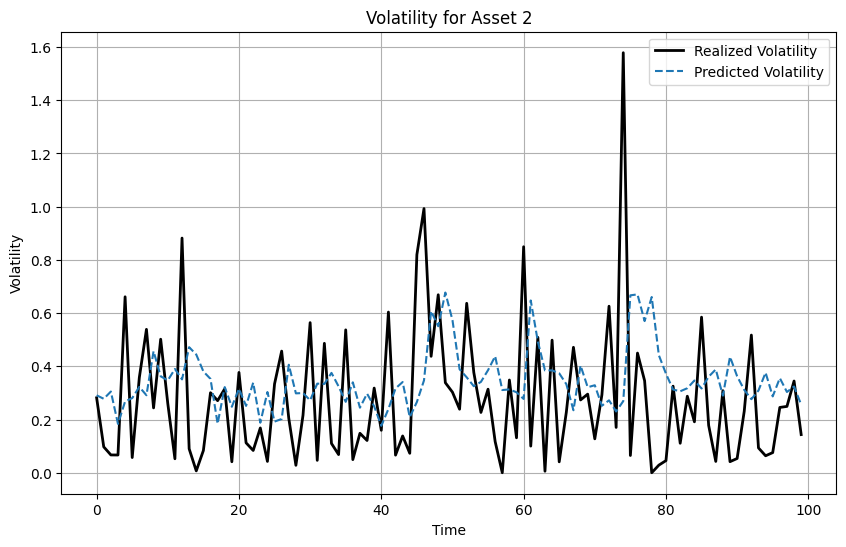

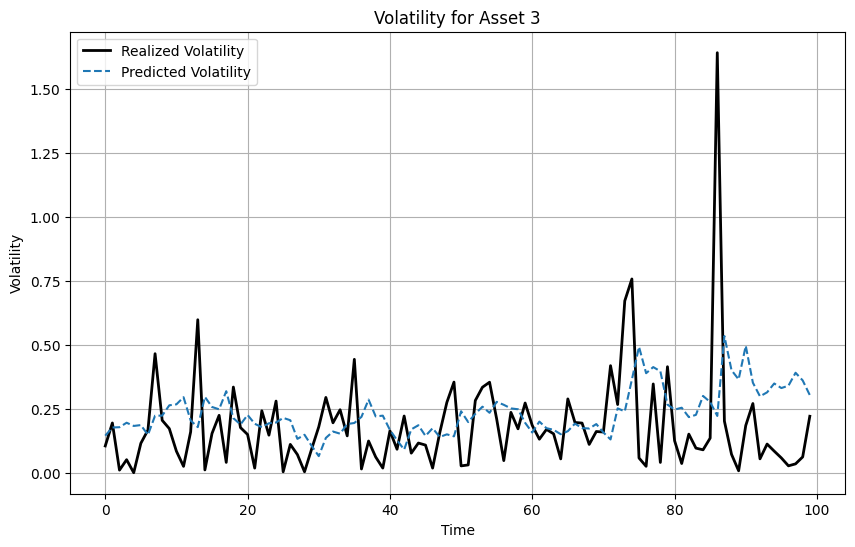

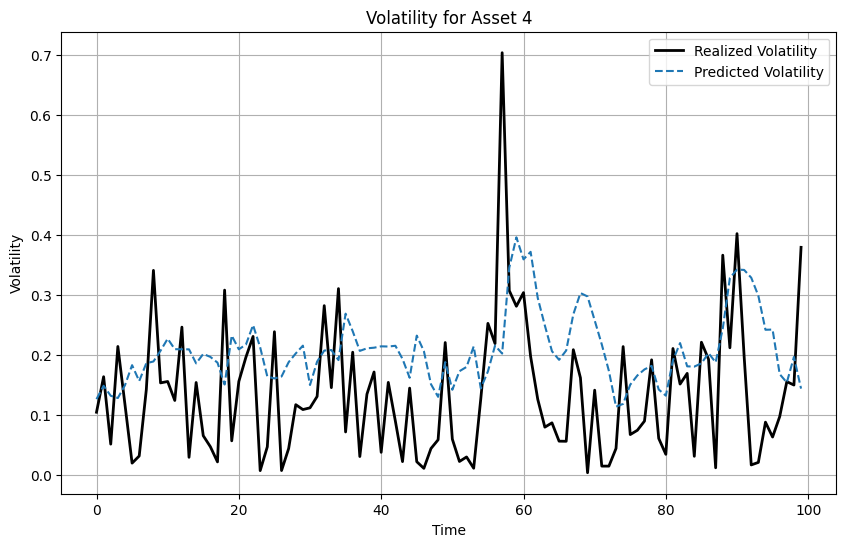

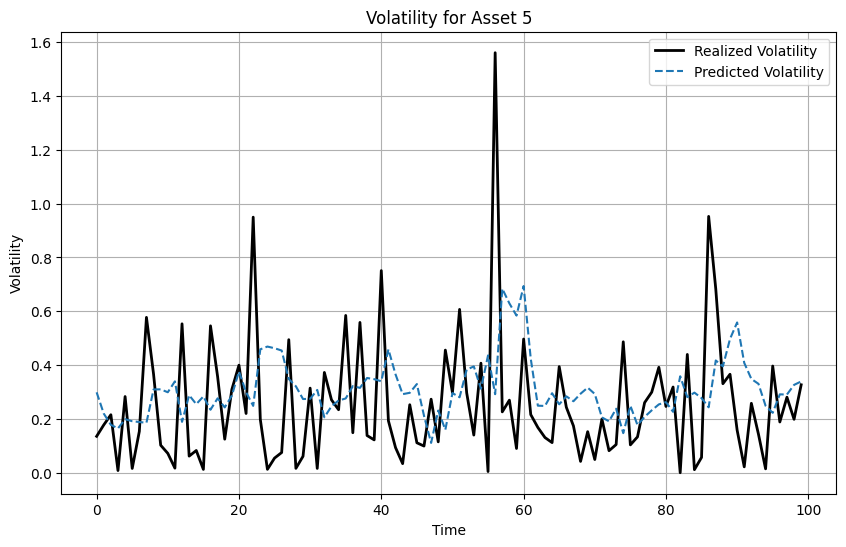

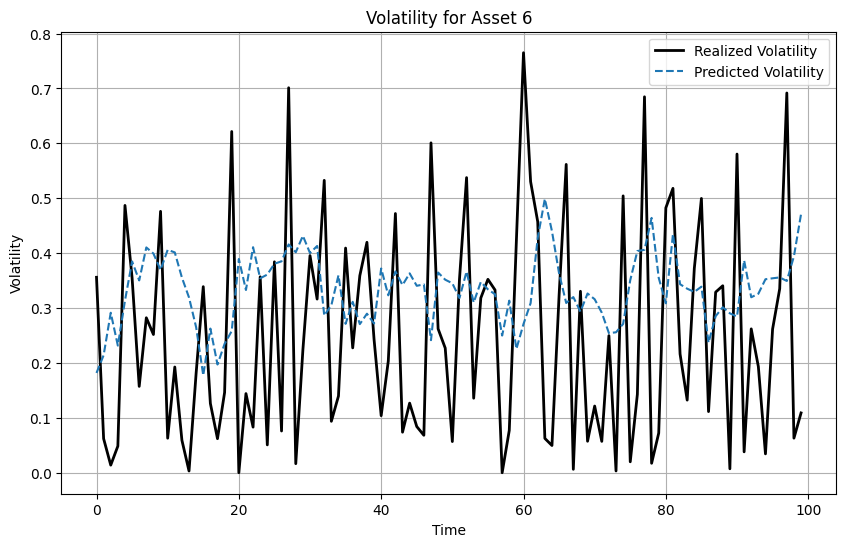

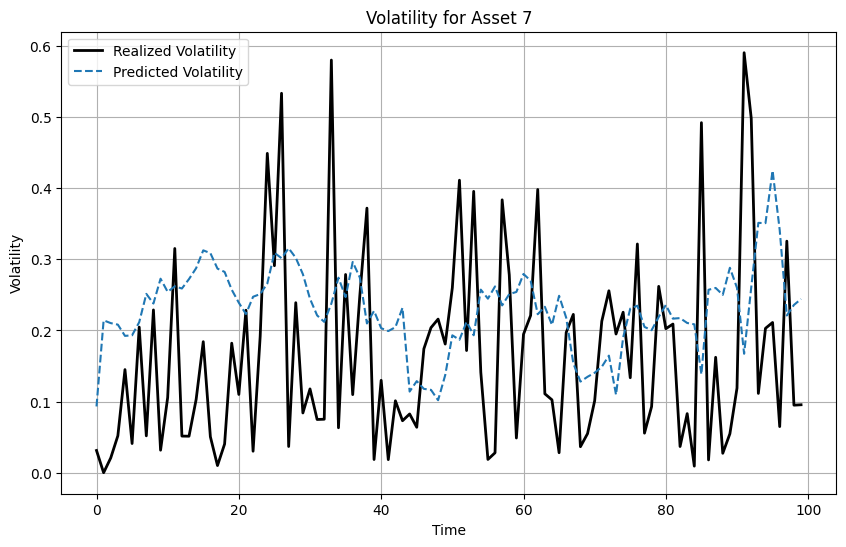

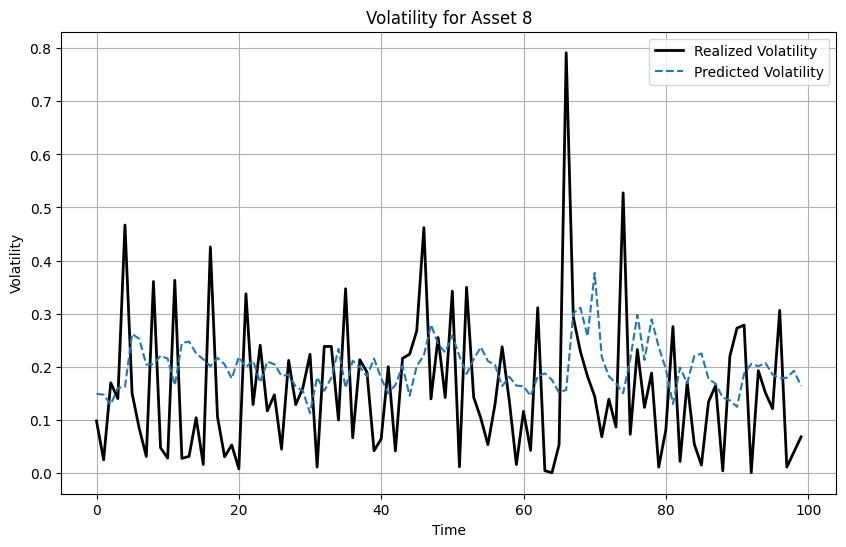

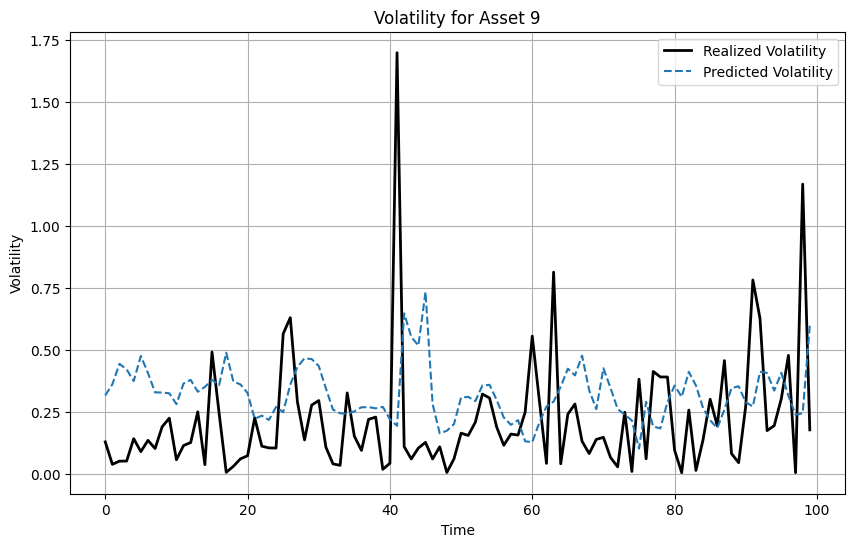

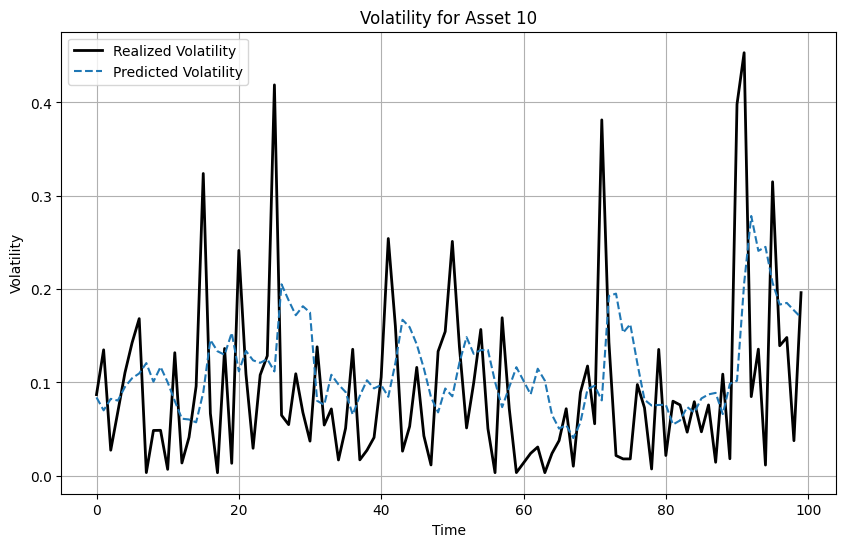

In [296]:
plot_realized_vs_predicted_per_model(Realized_vol, svr_vol)

In [285]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats.mstats import winsorize

In [291]:
def ewma_volatility(df, t, actif, span=5):
    """
    Calcule une volatilité lissée à l'aide d'un Exponential Weighted Moving Average (EWMA)
    autour de la date t pour l'actif donné.
    
    Args:
    df: DataFrame des rendements.
    t: L'index actuel (int).
    actif: Le nom de l'actif (colonne dans df).
    span: Période de lissage pour l'EWMA (plus c'est petit, plus le lissage est rapide).
    
    Returns:
    La volatilité lissée sur les jours t-3 à t+1.
    """
    vol_squared = df.loc[t-3:t+1, actif] ** 2 * 250  # Volatilité au carré annualisée
    ewma_vol = vol_squared.ewm(span=span, adjust=False).mean().iloc[-1]  # EWMA avec un fort poids sur t+1
    return np.sqrt(ewma_vol)

def create_lagged_features(series, lag):
    X, y = [], []
    for i in range(lag, len(series)):
        X.append(series[i-lag:i])  # Utilise les lag valeurs passées comme features
        y.append(series[i])  # La cible est la valeur actuelle de la série
    return pd.DataFrame(X), pd.Series(y)

# Fonction pour winsoriser un DataFrame et une série
def winsorize_dataframe(df, lower_percentile=0.01, upper_percentile=0.98):
    return df.apply(lambda col: winsorize(col, limits=[lower_percentile, 1-upper_percentile]))

# Exemples avec une série temporelle de volatilité réalisée lissée
def create_lagged_smooth_vol(df, actif, date_start, date_end, lag, span):
    """
    Crée des features retardées basées sur une volatilité lissée avec EWMA.
    """
    smooth_vols = []
    for t in range(date_start, date_end):
        smooth_vols.append(ewma_volatility(df, t, actif, span=span))
    
    # Créer des features à partir de la série lissée
    X, y = create_lagged_features(smooth_vols, lag)
    return X, y

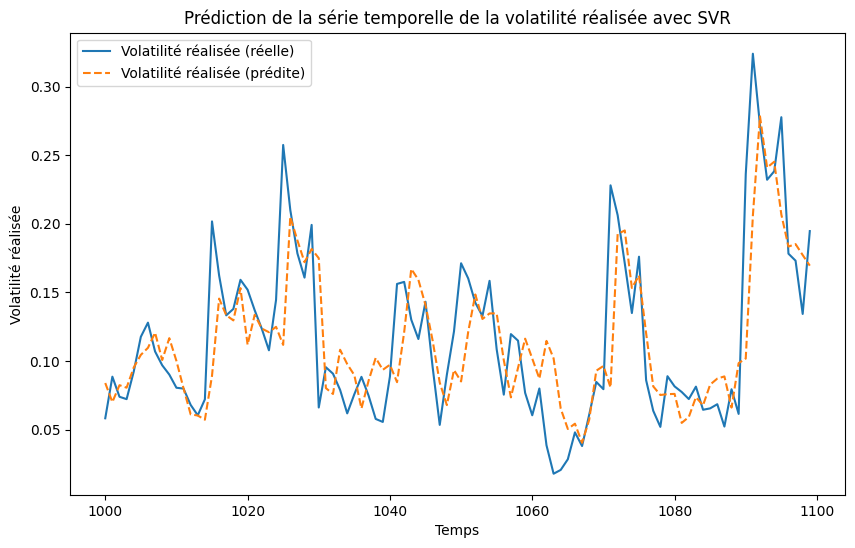

Valeurs prédites :  [0.08404293891275785, 0.07014884407758756, 0.08245821612309781, 0.08063762383285736, 0.09530861026616824, 0.10454639152430903, 0.1096882998756353, 0.12074239861270866, 0.10081093662513971, 0.11672041798949792, 0.10018363441841818, 0.08014239468643378, 0.06119579944097145, 0.060357204610749476, 0.057316914956300674, 0.08927534013192281, 0.1455518263832308, 0.1334685528963204, 0.12966582650407374, 0.15319040880796872, 0.1119436999316076, 0.1337788325259858, 0.12370172781323405, 0.12106438528169491, 0.12499909899758307, 0.11182045220153777, 0.20516801387035352, 0.18795968611078603, 0.1720752409586472, 0.18166303003213677, 0.17499204851779712, 0.08034665956690032, 0.07606138947591054, 0.10827344360663052, 0.09782795858931162, 0.08977437432329557, 0.06548216786996605, 0.0856886100988016, 0.10236550072869785, 0.09364650311125985, 0.09735021459228574, 0.08465093353202932, 0.12098274572341436, 0.16716063076959828, 0.15923885823859815, 0.14085187672606833, 0.1150450215889588

In [292]:
# Fonction pour créer les features avec des lags
def create_lagged_features(series, lag):
    X, y = [], []
    for i in range(lag, len(series)):
        X.append(series[i-lag:i])  # Utilise les lag valeurs passées comme features
        y.append(series[i])  # La cible est la valeur actuelle de la série
    return pd.DataFrame(X), pd.Series(y)
svr_vol=[[] for i in range(returns.shape[1])]
# Exemple avec une série temporelle de volatilité réalisée
vol_realized = [[np.sqrt(returns.loc[t, actif]**2 * 250) for t in range(600, 1100)] for actif in returns.columns]
for i,actif in enumerate(returns.columns):
    # Créer des observations à partir de 40 retards (lag)
    lag = 40
    span=5
    X, y = create_lagged_smooth_vol(returns, actif, date_start=600, date_end=1100, lag=lag, span=span)

    # Ajuster la longueur de X et y pour couvrir la période de 600 à 1100 avec lag
    # La taille de X et y correspond à 1100 - 600 = 500, mais on enlève le lag
    X_train, y_train = X.iloc[:1000 - 600 - lag], y.iloc[:1000 - 600 - lag]
    X_test, y_test = X.iloc[1000 - 600 - lag:], y.iloc[1000 - 600 - lag:]

    # Normalisation des données
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Modèle SVR avec kernel RBF
    svr = SVR(kernel='rbf', C=1.0, epsilon=0.02)

    # Entraîner le modèle sur l'ensemble d'entraînement
    svr.fit(X_train_scaled, y_train)

    # Prédictions sur l'ensemble de test
    y_pred = svr.predict(X_test_scaled)

    # Stocker les valeurs prédites et réalisées dans des listes
    predicted_vols = list(y_pred)
    svr_vol[i]=predicted_vols
    realized_vols = list(y_test)

# Affichage des résultats
plt.figure(figsize=(10, 6))
plt.plot(range(1000, 1100), y_test, label="Volatilité réalisée (réelle)")
plt.plot(range(1000, 1100), y_pred, label="Volatilité réalisée (prédite)", linestyle='--')
plt.title("Prédiction de la série temporelle de la volatilité réalisée avec SVR")
plt.xlabel("Temps")
plt.ylabel("Volatilité réalisée")
plt.legend()
plt.show()

# Affichage des listes
print("Valeurs prédites : ", predicted_vols)
print("Valeurs réalisées : ", realized_vols)

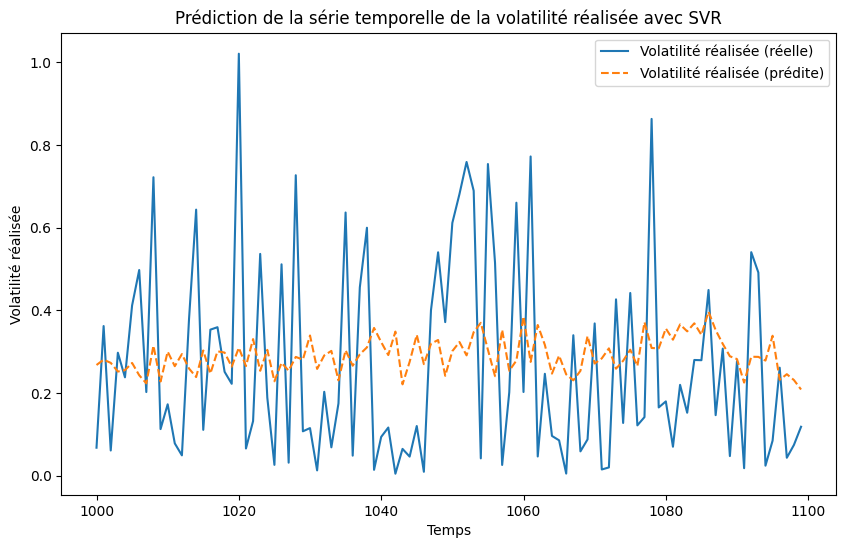

Valeurs prédites :  [0.267751440733756, 0.2806254695324905, 0.27292587816354724, 0.2519171142148544, 0.25537530666917596, 0.2727362184465374, 0.24294890983577985, 0.22334745517407156, 0.3145383446490607, 0.22777591582082135, 0.3000765207830227, 0.26486289166862975, 0.2941604751037103, 0.25921528498363433, 0.23855682818251064, 0.3029006544324935, 0.2470469963014002, 0.3009020559394332, 0.2978184559772701, 0.2637038835345622, 0.309546110450677, 0.2651655879667535, 0.33046555711913755, 0.2537189061741437, 0.30439268153254845, 0.22831255978334963, 0.27304457294475387, 0.25405948104820897, 0.28730786212194054, 0.2808366585143189, 0.33920320852350183, 0.2583251797058479, 0.2909170695581314, 0.3018876910804049, 0.23044606028351117, 0.30345710534552645, 0.26604325438346865, 0.29366863004116, 0.31041430302491874, 0.3574652543883356, 0.32328022889252445, 0.29179597509168864, 0.3486104778269071, 0.22093017511526294, 0.27540770984807694, 0.34085857349308224, 0.2698116650056087, 0.31925474041077745

In [286]:
lasso_vol=[[] for i in range(returns.shape[1])]
# Exemple avec une série temporelle de volatilité réalisée
vol_realized = [[np.sqrt(returns.loc[t, actif]**2 * 250) for t in range(600, 1100)] for actif in returns.columns]
def winsorize_dataframe(df, lower_percentile=0.01, upper_percentile=0.98):
    return df.apply(lambda col: winsorize(col, limits=[lower_percentile, 1-upper_percentile]))
for i,actif in enumerate(returns.columns):
    # Créer des observations à partir de 40 retards (lag)
    lag = 40
    X, y = create_lagged_features(vol_realized[0], lag)

    # Winsoriser X et y à 1% pour les valeurs basses et 98% pour les valeurs hautes
    X_winsorized = winsorize_dataframe(X, lower_percentile=0.01, upper_percentile=0.98)
    y_winsorized = winsorize(y, limits=[0.01, 0.02])

    # Ajuster la longueur de X et y pour couvrir la période de 600 à 1100 avec lag
    X_train, y_train = X_winsorized.iloc[:1000 - 600 - lag], y_winsorized[:1000 - 600 - lag]
    X_test, y_test = X_winsorized.iloc[1000 - 600 - lag:], y_winsorized[1000 - 600 - lag:]

    # Normalisation des données
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Modèle de régression Lasso
    lasso = Lasso(alpha=0.02)  # Vous pouvez ajuster alpha pour la régularisation

    # Entraîner le modèle sur l'ensemble d'entraînement
    lasso.fit(X_train_scaled, y_train)

    # Prédictions sur l'ensemble de test
    y_pred = lasso.predict(X_test_scaled)

    # Stocker les valeurs prédites et réalisées dans des listes
    predicted_vols = list(y_pred)
    lasso_vol[i]=predicted_vols
    realized_vols = list(y_test)

# Affichage des résultats
plt.figure(figsize=(10, 6))
plt.plot(range(1000, 1100), y_test, label="Volatilité réalisée (réelle)")
plt.plot(range(1000, 1100), y_pred, label="Volatilité réalisée (prédite)", linestyle='--')
plt.title("Prédiction de la série temporelle de la volatilité réalisée avec SVR")
plt.xlabel("Temps")
plt.ylabel("Volatilité réalisée")
plt.legend()
plt.show()

# Affichage des listes
print("Valeurs prédites : ", predicted_vols)
print("Valeurs réalisées : ", realized_vols)


In [ ]:
def daily_vol_strategy(vol_predictions, returns):
    # Calculer les poids inverses de la volatilité prédite
    weights = 1 / vol_predictions
    # Normaliser les poids pour que la somme soit égale à 1
    weights = weights.div(weights.sum(axis=1), axis=0)
    
    # Calcul des performances du portefeuille (rendements pondérés)
    portfolio_returns = (weights * returns).sum(axis=1)
    
    return portfolio_returns

# Exemple d'application de la stratégie
portfolio_returns = daily_vol_strategy(vol_predictions, returns)